In [1]:
%pylab inline

import pandas as pd
from pyro.optim import Adam
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from pyro.contrib.brm import defm
from pyro.contrib.brm.fit import marginals, fitted, summary
from pyro.contrib.brm.pyro_backend import backend as pyro_backend
from pyro.contrib.brm.numpyro_backend import backend as numpyro

Populating the interactive namespace from numpy and matplotlib


## Data

In [2]:
df = pd.read_csv('rugged_data.csv', encoding="ISO-8859-1")
df = df[["cont_africa", "rugged", "rgdppc_2000"]]
df = df[np.isfinite(df.rgdppc_2000)]
df['cont_africa'] = pd.Categorical(df['cont_africa'])
df["log_gdp"] = np.log(df["rgdppc_2000"])
del df['rgdppc_2000']
df = df[df['cont_africa'] == 1]
del df['cont_africa']

In [3]:
df.head()

,rugged,log_gdp
2,0.858,7.492609
15,1.780,6.432380
17,0.141,6.866123
18,0.236,6.906170
32,0.181,8.949301


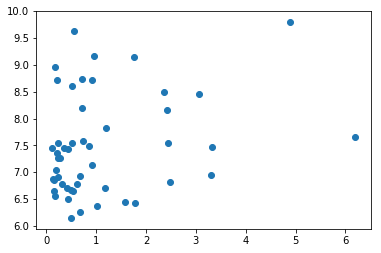

In [4]:
scatter(df['rugged'], df['log_gdp']);

## The Model

In [5]:
model = defm('log_gdp ~ 1 + rugged', df)
model

Population
----------------------------------------
Coef Priors:
intercept       | Cauchy(loc=0.0, scale=1.0)
rugged          | Cauchy(loc=0.0, scale=1.0)
Response
----------------------------------------
Family: Normal()
Link:
  Parameter: mu
  Function:  identity
Priors:
sigma           | HalfCauchy(scale=3.0)

## Inference

It's straight forward to perform inference using Pyro for either HMC or SVI, or NumPyro for HMC. The only thing that needs to changes is the arguments to `fit`. Everything else, e.g. the model definition, and working with the posterior, remains unchanged.

In [6]:
fit = model.fit(iter=1000)

sample: 100%|██████████| 1500/1500 [00:18<00:00, 82.36it/s, step size=6.24e-01, acc. prob=0.904] 


In [7]:
fit2 = model.fit(backend=numpyro, iter=1000)

sample: 100%|██████████| 1000/1000 [00:01<00:00, 737.08it/s, 7 steps of size 7.69e-01. acc. prob=0.84]


In [8]:
# Learning rate is crucial here. This is setting is taken from the Pyro bayesian regression example.
fit3 = model.fit(algo='svi',
                 iter=4000, num_samples=1000,
                 autoguide=AutoMultivariateNormal,
                 optim=Adam({'lr':0.03}))

iter: 4000 | loss: 76.166 


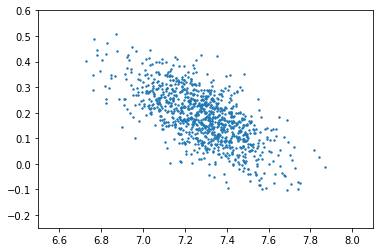

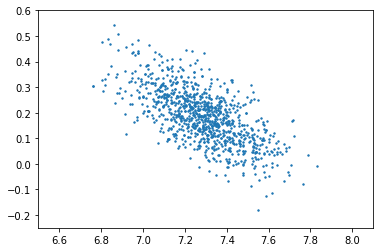

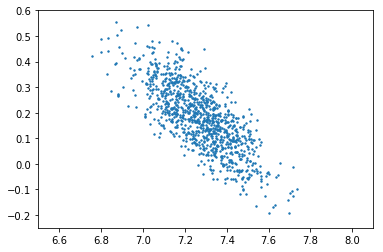

In [9]:
def plot_posterior(fit):
    figure()
    xlim((6.5, 8.1))
    ylim((-0.25, 0.6))
    # TODO: Seems like it would be useful to be able to query by the names
    # that appear in e.g. `marginals(fit)` here. So, 'b_intercept', etc.
    bs = fit.posterior.get_param('b')
    scatter(bs[:,0], bs[:,1], s=2)

plot_posterior(fit)
plot_posterior(fit2)
plot_posterior(fit3)